In [5]:
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from DAX.HelpFunctions.get_dax_data import get_dax_data
from datetime import timedelta
from HelpFunctions.calc_score import evaluate_horizon
import pandas as pd
from DAX.Models.baseline import baseline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from DAX.Models.mix_models import mix_models
# import importlib
# importlib.reload(Energy.Models)

In [6]:
df = get_dax_data()

In [7]:
# We have to start with the tuesday data
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [8]:
df_cval.tail()

,Close,ret1,ret2,ret3,ret4,ret5
2023-11-08,15229.599609,0.506613,0.616686,0.265294,0.566290,2.031917
2023-11-09,15352.540039,0.804006,1.310618,1.420692,1.069299,1.370296
2023-11-10,15234.389648,-0.772559,0.031447,0.538060,0.648134,0.296741
2023-11-13,15345.000000,0.723434,-0.049125,0.754881,1.261494,1.371568
2023-11-14,15614.429688,1.740578,2.464012,1.691453,2.495459,3.002072


In [35]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w+1} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)
        
        pred = None        
        if callable(model['function']):
            print('IsFn')
            pred = model['function'](df_before)
        else: 
            print('IsNotFn')
            pred = mix_models(model['function'][0], model['function'][1], df_before)
        # Makes sure we try to find observations for dates that have an observation (e.g. 05-01 is missing)
        dates = [[horizon+1, d] for horizon,d in enumerate(pred['forecast_date']) if d in df.index]
        pred = pred.set_index('forecast_date')

        
        # Add observations to pred
        pred['observation'] = ''
        pred['score'] = ''
        for h,d in dates:
            # Look up the right observation for date d
            o = df.loc[d][f'ret{h}']
            pred.loc[d,'observation'] = o
    
        # Add scores to pred
        for index, row in pred.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['observation']
            
            
            
            print(f'Obs: :{observation}:')
            print(type(observation))
            score = evaluate_horizon(quantile_preds, observation)
            
            pred.at[index, 'score'] = score
            
        evaluation = pd.concat([evaluation, pred])
    evaluation = evaluation.sort_index()
    
    return evaluation

In [48]:
from DAX.Models.garch11_t import garch11_t
from DAX.Models.garch11 import garch11
from DAX.Models.baseline_100 import baseline_100
from DAX.Models.baseline_300 import baseline_300

models = [
    {
        'name': 'baseline',
        'function': baseline
     },
    {
        'name': 'garch11',
        'function': garch11
     },
    # {
    #     'name': 'garch11_t',
    #     'function': garch11_t
    #  },
    {
        'name': 'baseline_garch11',
        'function': [[baseline, garch11],[0.5,0.5]]
     },
    # {
    #     'name': 'baseline_300',
    #     'function': baseline_300
    #  },
    # {
    #     'name': 'baseline_100',
    #     'function': baseline_100
    #  },
]


In [49]:
evaluate_models(models, df, 100, weeks=True)

*********** Start the evaluation of Model baseline ***********
Iteration 1 of 100
IsFn
Obs: :0.24379715599138763:
<class 'numpy.float64'>
Obs: :1.0799261936377036:
<class 'numpy.float64'>
Obs: :0.9678595355834929:
<class 'numpy.float64'>
Obs: :0.9628296116808599:
<class 'numpy.float64'>
Obs: :1.3618263708194078:
<class 'numpy.float64'>
Iteration 2 of 100
IsFn
Obs: :0.8040058240867509:
<class 'numpy.float64'>
Obs: :0.031447221579838924:
<class 'numpy.float64'>
Obs: :0.7548811111321996:
<class 'numpy.float64'>
Obs: :2.495458973270992:
<class 'numpy.float64'>
Obs: :3.3483286123544787:
<class 'numpy.float64'>
Iteration 3 of 100
IsFn
Obs: :1.465626641081741:
<class 'numpy.float64'>
Obs: :1.7666232548423366:
<class 'numpy.float64'>
Obs: :1.4152303960800694:
<class 'numpy.float64'>
Obs: :1.5253042746907752:
<class 'numpy.float64'>
Obs: :2.0319168708628155:
<class 'numpy.float64'>
Iteration 4 of 100
IsFn
Obs: :-1.087872420866276:
<class 'numpy.float64'>
Obs: :-1.3845547115455048:
<class 'numpy

In [62]:
with open('./Model evaluations/BL_GARCH11_MM-BL-GARCH11.pkl', 'wb') as f:
    pickle.dump(models, f)
#         
# with open('./Model evaluations/baseline.pkl', 'rb') as f:
#     models = pickle.load(f)

In [51]:
models[0]['evaluation']

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,observation,score
forecast_date,,,,,,,,,
2021-12-23,DAX,1 day,-2.710994,-0.496173,0.070684,0.662321,2.438222,1.038867,2.557984
2021-12-24,DAX,2 day,-3.936562,-0.760600,0.142980,0.907245,3.132972,,None
2021-12-27,DAX,5 day,-4.759447,-0.859430,0.161798,1.199638,3.890326,2.479515,6.339493
2021-12-28,DAX,6 day,-5.246158,-0.968346,0.228679,1.396319,4.574074,3.287409,8.514252
2021-12-29,DAX,7 day,-5.753083,-1.097561,0.378065,1.488180,5.192237,2.586812,6.24615
...,...,...,...,...,...,...,...,...,...
2023-11-16,DAX,1 day,-3.321265,-0.551383,0.060969,0.720873,2.719772,0.243797,1.121008
2023-11-17,DAX,2 day,-4.087895,-0.823250,0.072355,0.987420,3.570492,1.079926,2.480838
2023-11-20,DAX,5 day,-5.259161,-0.917655,0.161798,1.224285,4.628697,0.96786,2.371424


In [52]:
horizons = [str(i) + " day" for i in (1, 2, 5, 6, 7)]
scores = []
names = []
for m in models:
    scores_m = m['evaluation'].loc[:,('horizon','score')]
    names.append(f'horizon_{m["name"]}')
    names.append(m["name"])
    scores.append(scores_m)

score_df = pd.concat(scores, axis=1)
score_df.columns = names

In [53]:
score_df

,horizon_baseline,baseline,horizon_garch11,garch11,horizon_baseline_garch11,baseline_garch11
forecast_date,,,,,,
2021-12-23,1 day,2.557984,1 day,2.511572,1 day,2.534778
2021-12-24,2 day,None,2 day,None,2 day,None
2021-12-27,5 day,6.339493,5 day,6.702358,5 day,6.520925
2021-12-28,6 day,8.514252,6 day,8.961143,6 day,8.737698
2021-12-29,7 day,6.24615,7 day,6.676247,7 day,6.461199
...,...,...,...,...,...,...
2023-11-16,1 day,1.121008,1 day,1.113846,1 day,1.117427
2023-11-17,2 day,2.480838,2 day,2.657581,2 day,2.476703
2023-11-20,5 day,2.371424,5 day,3.179826,5 day,2.775625


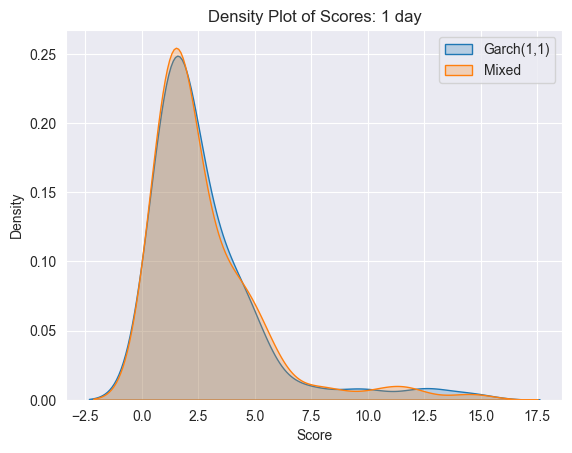

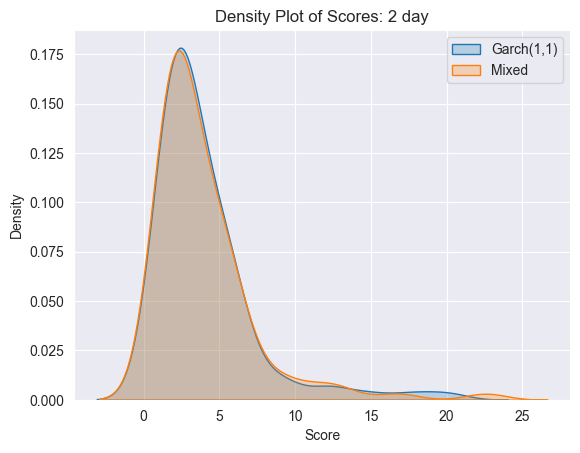

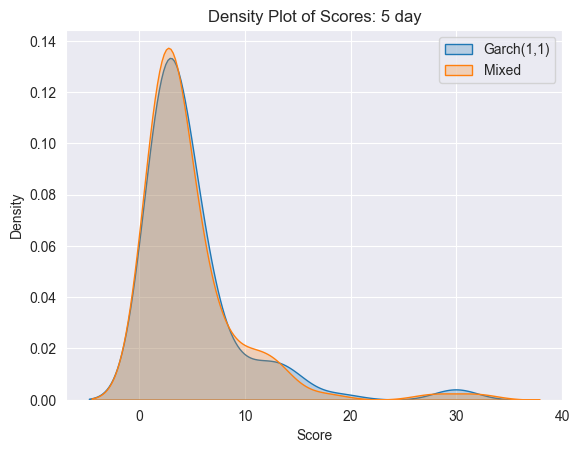

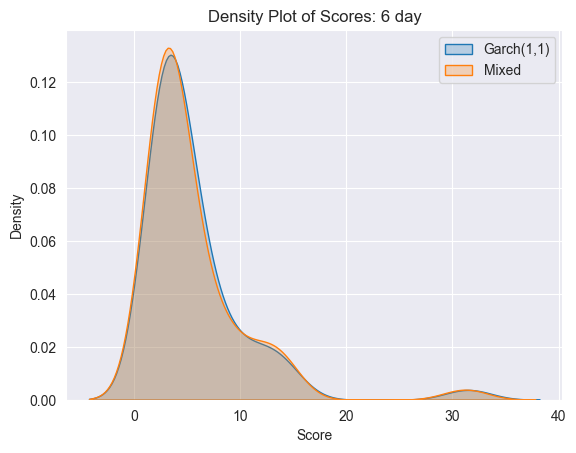

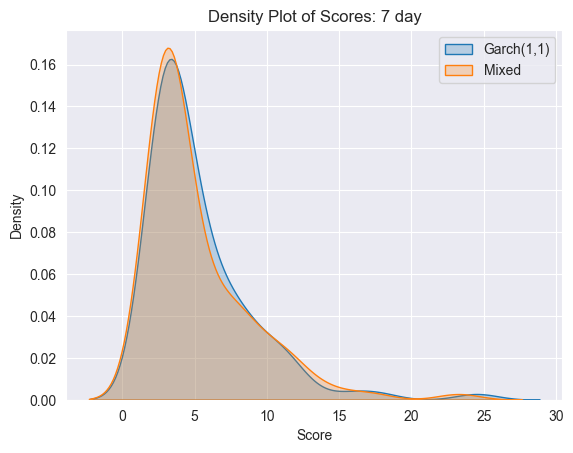

In [61]:
for horizon in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    filtered_df = score_df[score_df['horizon_garch11'] == horizon]
    # sns.kdeplot(data=filtered_df['baseline'], fill=True, label='Baseline')
    sns.kdeplot(data=filtered_df['garch11'], fill=True, label='Garch(1,1)')
    sns.kdeplot(data=filtered_df['baseline_garch11'], fill=True, label='Mixed')
    # sns.kdeplot(data=filtered_df['baseline_300'], fill=True, label='Baseline 300')
    
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {horizon}')
    plt.legend()
    
    # plt.xlim(0,8)
    # Display the plot
    plt.show()

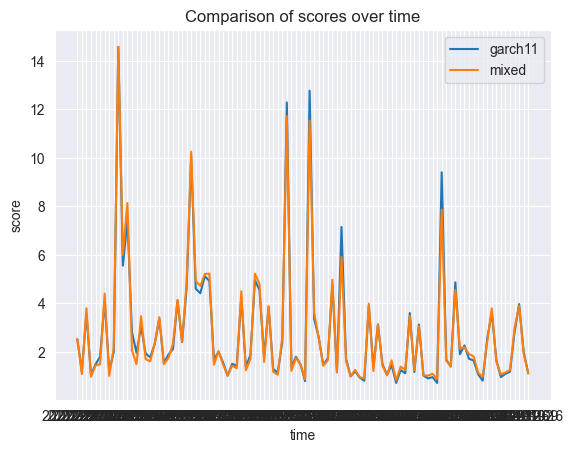

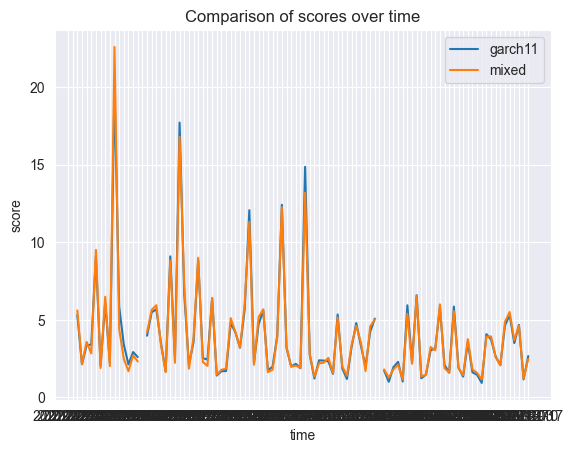

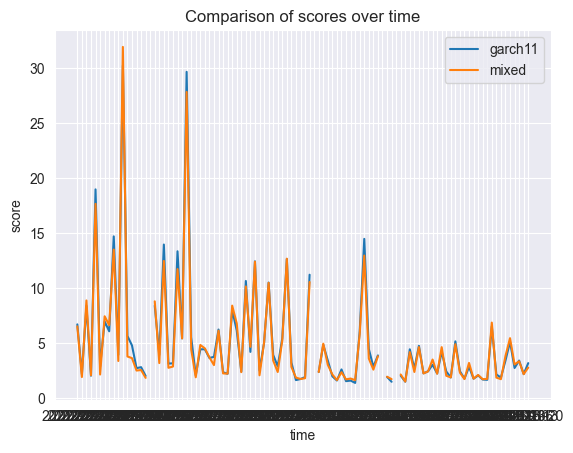

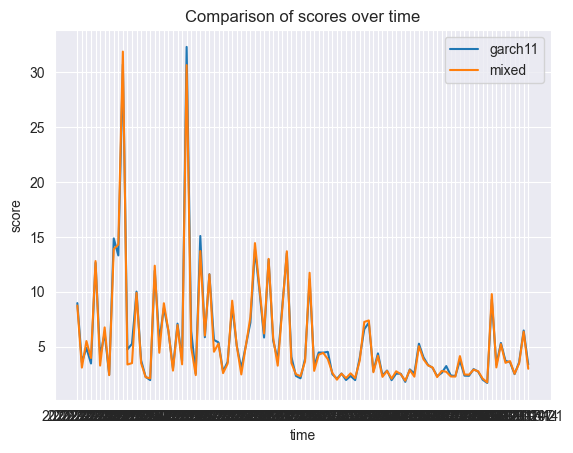

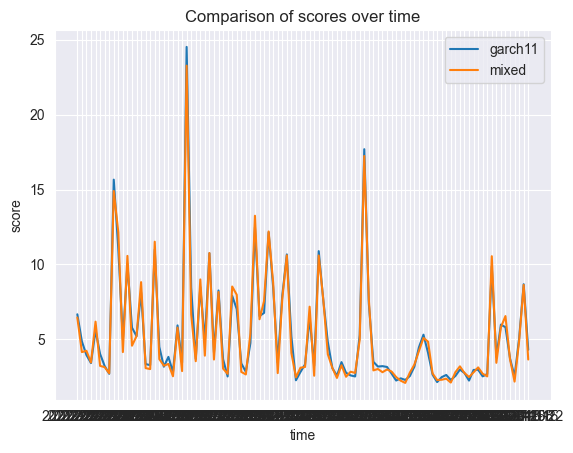

In [59]:
for horizon in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    filtered_df = score_df[score_df['horizon_garch11'] == horizon]

    # Plot values from two columns over time
    # filtered_df = filtered_df[score_df['garch11'].notna()]
    # plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
    # plt.plot(filtered_df.index, filtered_df['baseline'], label='baseline')
    # plt.plot(score_df_36_no_na.index, score_df_36_no_na['model2: 36 hour'], label='model2')
    plt.plot(filtered_df.index, filtered_df['garch11'], label='garch11')
    plt.plot(filtered_df.index, filtered_df['baseline_garch11'], label='mixed')
    # plt.plot(filtered_df.index, filtered_df['garch11_t'], label='garch11_t')
    
    
    # Adding labels and title
    plt.xlabel('time')
    plt.ylabel('score')
    plt.title('Comparison of scores over time')
    
    # Display legend
    plt.legend()
    
    # Show the plot
    plt.show()